In [21]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('deep')
sns.set_context('notebook')

import pandas as pd
import numpy as np
import numpy.random as random
import re, sys

from sklearn.model_selection import train_test_split
#from leven import levenshtein

import torch
import torch.nn
from torch import optim
from torch.nn import Parameter
from torch.autograd import Variable
from torch.nn.functional import hardtanh

import radial_basis, tpr_global, tpr_ops, tpr_pivoter, tpr_encoder, tpr_decoder, tpr_redup
radial_basis = reload(radial_basis)
tpr_global = reload(tpr_global)
tpr_ops = reload(tpr_ops)
tpr_pivoter = reload(tpr_pivoter)
tpr_encoder = reload(tpr_encoder)
tpr_decoder = reload(tpr_decoder)
tpr_reduper = reload(tpr_redup)
from radial_basis import *
from tpr_global import *
from tpr_ops import *
from tpr_pivoter import *
from tpr_encoder import *
from tpr_decoder import *
from tpr_redup import *

print 'done'

done


In [22]:
#help(pd.read_table)

In [29]:
print 'importing data'

# select data set, initialize global variables
data_select = 2
datadir = '~/Dropbox/TensorProductStringToStringMapping/'
if data_select == 1:
    datfile = '~/Dropbox/AlbrightHayes2003/RuleBasedLearnerEnglishFiles/CELEXverbs.txt'
    dat = pd.read_table(datfile, sep='\t', header=-1)
    dat.columns = ['freq', 'stem', 'output', 'type']
    dat['stem'] = [str(x).lower() for x in dat.stem]
    dat['output'] = [x+x for x in dat.stem] # complete redup
    dat = dat[(dat.stem.str.len() <= 6)]
    dat = dat.reset_index()
    dat['stem'] = [string2sep(x) for x in dat.stem]
    dat['output'] = [string2sep(x) for x in dat.output]

    from string import ascii_lowercase
    syms  = [x for x in ascii_lowercase]
if data_select == 2:
    datfile = datadir + 'coling2018/data/amele_verb_cv/dat.csv'
    dat = pd.read_table(datfile, sep=',', header=0, encoding='utf-8')
    vowels = ['a', 'e', 'i', 'o', 'u']
    dat['output'] = [x+' '+x for x in dat.stem]

print dat.head()
print 'number of stem-output pairs:', len(dat)

importing data
              stem                           output       output_gloss
0    b a ʔ i s e n      b a ʔ i s e n b a ʔ i s e n     as he came out
1    b a g a w e n      b a g a w e n b a g a w e n      as he pierced
2        b a s e n              b a s e n b a s e n  as she gave birth
3            b e n                      b e n b e n     as he came out
4  b e l e i g i n  b e l e i g i n b e l e i g i n       as they went
number of stem-output pairs: 101


symbol set (n = 21):
⋊ a b d e f g gb h i j l m n o s t u w ʔ ⋉
21 24 25 25


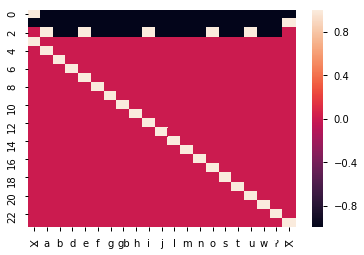

In [30]:
# collect symbols from data
syms = set([x for y in dat.output for x in y.split(' ')])
syms = sorted([x for x in syms])
rando = [False, True][0]

tpr_global.init(syms, vowels_=vowels, nrole_=25, random_fillers=rando, random_roles=rando); tpr_ops.init()
syms, sym2id, nfill, nrole = tpr_global.syms, tpr_global.sym2id, tpr_global.nfill, tpr_global.nrole
dfill, drole = tpr_global.dfill, tpr_global.drole
print 'symbol set (n = '+ str(len(syms)) +'):'
for i in xrange(len(syms)):
    print syms[i],
print
print nfill, dfill, nrole, drole

sns.heatmap(tpr_global.F.data.numpy(), xticklabels=syms)
plt.show()

In [31]:
# train and test split
def make_split(dat, test_size=0.5):
    train, test = train_test_split(dat, test_size=0.5)
    return train, test

def make_batch(dat, nbatch=20, debug=0):
    batch = dat.sample(nbatch)
    stems = [x for x in batch['stem']]
    stems = [string2delim(x) for x in stems]

    targs = [x for x in batch['output']]
    targs = [string2delim(x) for x in targs]

    Stems = Variable(torch.zeros(nbatch, dfill, nrole))
    for i,stemi in enumerate(stems):
        Stems.data[i,:,:] = string2tpr(stemi, False)
        if debug:
            print '__'+stemi+'__', '->',
    
    targ_len = [0]*nbatch
    Targs = Variable(torch.LongTensor(nbatch,nrole))
    Targs.data[:] = -1
    for i,targi in enumerate(targs):
        x = string2vec(targi, False)
        targ_len[i] = len(x)
        Targs.data[i,0:len(x)] = torch.LongTensor(x)
        if debug:
            print '__'+targi+'__'
    
    max_targ_len = np.max(np.array([len(x.split(' ')) for x in targs]))
    #print 'max target length:', max_targ_len
    if max_targ_len >= nrole:
        print 'error: max target length >= nrole'
        sys.exit(0)
    return stems, targs, Stems, Targs, targ_len

def get_accuracy(dat, affixer, decoder, exact_only=True):
    stems, targs, Stems, Targs, targ_len = make_batch(dat, len(dat))
    out = affixer(Stems, max_len=max(targ_len))
    out = decoder.decode(out)
    accuracy, avg_mismatch, n = 0.0, 0.0, len(dat)
    errors = []
    for i in xrange(n):
        outi = out[i] 
        targi = targs[i]
        #print stems[i], outi, '['+ targi +']'
        if outi == targi:
            accuracy += 1.0
        else:
            errors.append((outi, targi))
        if exact_only:
            continue
        outi = outi.split(' ')
        targi = targi.split(' ')
        nout, ntarg = len(outi), len(targi)
        p = nout if nout<=ntarg else ntarg
        avg_mismatch += np.sum([1.0 if targi[j] != outi[j] else 0.0 for j in xrange(p)])
        avg_mismatch += np.abs(nout-ntarg)
    accuracy = np.round(accuracy / float(n), 3)
    if exact_only:
        return accuracy
    avg_mismatch = np.round(avg_mismatch / float(n), 3)
    print errors
    return (accuracy, avg_mismatch)

In [32]:
# test batch construction for current data set
stems, targs, Stems, Targs, targ_len = make_batch(dat, len(dat), 0)
print 'done'

affixer = Reduplicator()
affixer.pivoter.init_prefix()
affixer.delimiter.init_full()
affixer.morph_attender.tau.data[:] = 5.0
affixer.posn_attender.tau.data[:] = 5.0
decoder = Decoder()
max_len = max(targ_len)
out = affixer(Stems, max_len=max_len)
print 'done'

print tpr_global.F.shape

#base_begin, base_end = delimiter(Stems)
#print base_begin[1,:].data.numpy().transpose()
#print base_end[1,:].data.numpy().transpose()

print decoder.decode(Stems)[1], '->',
print decoder.decode(out)[1]

done
done
torch.Size([24, 21])
⋊ h a g a l e n ⋉ -> ⋊ h a g a l e n h a g a l e n ⋉


In [33]:
def train_and_test(max_epochs=5000, verbosity=1):
    # initialize model
    affixer = Reduplicator(); affixer.init()
    if 1:
        print 'cheating ...'
        #affixer.pivoter.init_edge()
        #affixer.delimiter.init_full()
        #affixer.morph_attender.tau.data[:] = 5.0
        #affixer.posn_attender.tau.data[:] = 5.0
    
    decoder = Decoder()
    lr = 0.10; dc = 0.0
    affixer_optim = optim.Adagrad(affixer.parameters(), lr, weight_decay=dc)
    decoder_optim = optim.Adagrad(decoder.parameters(), lr, weight_decay=dc)
    criterion = nn.NLLLoss()
    
    # train model
    print 'training ...',
    train, test = make_split(dat)
    nbatch = 10
    posn_out = Variable(torch.LongTensor(nbatch), requires_grad=False).zero_()
    nepoch = 0
    for epoch in xrange(max_epochs):
        loss = 0.0
        
        stems, targs, Stems, Targs, targ_len = make_batch(train, nbatch)
        max_len = max(targ_len)
        out = affixer(Stems, max_len=max_len)
        
        losses = []
        for j in xrange(max_len):
            posn_out.fill_(j)
            logprob = decoder(out, posn_out)
            for i in xrange(nbatch): # xxx avoid this loop
                k = Targs[i,j]
                if k.data[0] == -1: continue
                lossi = criterion(logprob[i,:].view(1,nfill), k)
                losses.append(lossi.data[0])
                loss += lossi
        
        train_acc = None
        if (epoch > 1 and epoch % 100 == 0) and verbosity>0:
            print
            print epoch, loss.data[0] / float(nbatch), 
            train_acc = get_accuracy(train, affixer, decoder)
            print 'train_acc =', train_acc
            print '  ', stems[0], '  ', decoder.decode(out)[0]
        if loss.data[0] / float(nbatch) < 0.01:
            nepoch = epoch
            break
        losses_bad = [i for i,x in enumerate(losses) if np.isnan(x)]
        if len(losses_bad)>0:
            #print 'losses_bad:', losses_bad
            print affixer.morph_attender.tau.data[0],
            print affixer.posn_attender.tau.data[0]
            print affixer.affix.data
            print stems[i], '  ', j, '  ', logprob.data.numpy()
            #print affixer.affix.data.numpy()
            sys.exit(0)
        
        loss.backward()
        affixer_optim.step()
        decoder_optim.step()
    print 'done'; print
    
    # accuracy on test and train data
    train_acc = get_accuracy(train, affixer, decoder, False)
    test_acc  = get_accuracy(test,  affixer, decoder, False)
    print 'nepochs:', nepoch, 'train_acc:', train_acc, 'test_acc:', test_acc
    return affixer, decoder

In [36]:
affixer, decoder = None, None
nruns = 1
for i in xrange(nruns):
    affixer, decoder = train_and_test(max_epochs=2000, verbosity=1)

cheating ...
training ...
100 8.74408111572 train_acc = 0.0
   ⋊ gb a t a n e n ⋉    ⋊ gb a t a n e e n t t a n e n ⋉

200 2.63244915009 train_acc = 0.74
   ⋊ n u e n ⋉    ⋊ n u e n n u e n ⋉

300 0.0453124195337 train_acc = 1.0
   ⋊ b u j e n ⋉    ⋊ b u j e n b u j e n ⋉
done

[]
[(u'\u22ca o d o n \u22ca o d o n \u22c9', u'\u22ca o d o n o d o n \u22c9'), (u'\u22ca o n \u22ca o n \u22c9', u'\u22ca o n o n \u22c9')]
nepochs: 354 train_acc: (1.0, 0.0) test_acc: (0.96099999999999997, 0.19600000000000001)


=affixer parameters=
tau0:   4.68122577667
tau1:  4.81097459793



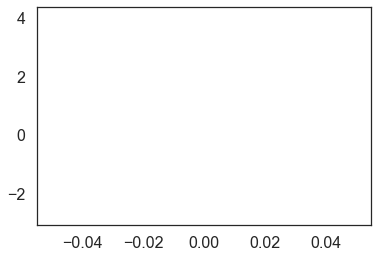


[-2.35995722]
[ 2.01730776]

=decoder parameters=
tau:   4.83432674408


In [79]:
sns.set()
sns.set_style('white')
sns.set_context('poster')
cmap = sns.cubehelix_palette(n_colors=256, start=0.3, rot=-0.5, reverse=False, as_cmap=True)

print '=affixer parameters='
print 'tau0:  ', affixer.morph_attender.tau.data[0]
print 'tau1: ', affixer.posn_attender.tau.data[0]
print

#fig, ax = plt.subplots(figsize=(8.5,10))
#sns.heatmap(affixer.delimiter.matcher_begin.weight.data.numpy() ) #, yticklabels=syms)
#plt.show()

wts = affixer.delimiter.matcher_begin.weight.data.squeeze(-1).numpy()
plt.plot(wts)
wts = affixer.delimiter.matcher_end.weight.data.squeeze(-1).numpy()
plt.plot(wts)
plt.show()

print 
print affixer.delimiter.prev_begin.data.numpy()
print affixer.delimiter.prev_end.data.numpy()
print

print '=decoder parameters='
print 'tau:  ', decoder.tau.data[0]

In [140]:
affixer = Reduplicator(); affixer.init()
decoder = Decoder()

nbatch = 10
train, test = make_split(dat)
stems, targs, Stems, Targs, targ_len = make_batch(train, nbatch)
max_len = max(targ_len)
out = affixer(Stems, max_len=max_len)

print decoder.decode(out)[0]

pivot: [ 0.00055181  0.00048524  0.00076489  0.00145391  0.00069053  0.00076489
  0.00238732  0.01654598  0.0854909   0.08549092  0.0854909   0.08549088
  0.08549088  0.0854909   0.0854909   0.08549088  0.0854909   0.0854909
  0.0854909   0.        ]
base_begin: [ 0.00048038  0.00034092  0.00071249  0.0009205   0.0006413   0.00071249
  0.00180769  0.01348163  0.07267873  0.07267874  0.07267873  0.07267871
  0.07267871  0.07267871  0.07267873  0.07267871  0.07267873  0.07267873
  0.07267873  0.        ]
⋊ w a a y l a y y ⋉


In [222]:
train, test = make_split(dat)
print get_accuracy(test,  affixer, decoder, False)
print get_accuracy(train, affixer, decoder, False)

RuntimeError: size mismatch, m1: [1614 x 36], m2: [24 x 1] at /Users/soumith/minicondabuild3/conda-bld/pytorch_1512379211386/work/torch/lib/TH/generic/THTensorMath.c:1416

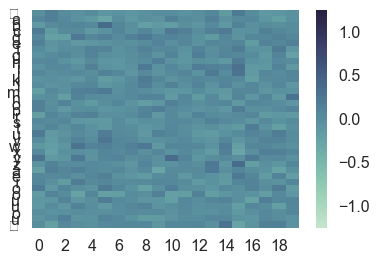

In [32]:
#from matplotlib.colors import ListedColormap
#cmap = sns.cubehelix_palette(as_cmap=True)

stem = ' '.join('record')
T_stem = string2tpr(stem)
sns.heatmap(T_stem.numpy(), yticklabels=syms, cmap=cmap, vmin=-1.25, vmax=1.25) #"BuPu")#cmap="BuPu")#, cmap="Blues")
plt.show()

In [13]:
out, traces = affixer(Stems, trace=True)
i = 0
#pivot = affixer.pivoter(stem)
#print 'pivot prob:', [x for x in pivot[i,:].data.numpy()]

pred = decoder.decode(out)
npred = len(pred[i].split(' '))
print stems[i], ' -> ', targs[i], '   ', pred[i]

out = affixer(Stems)

sns.heatmap(out.data[i,:,:].numpy(), yticklabels=syms, cmap=cmap, vmin=-1.25, vmax=1.25)
#cmap=sns.light_palette('blue', as_cmap=True))#'Blues')#cmap="Blues") "RdBu"
plt.show()

trace = pd.DataFrame(traces)
trace = trace.melt(id_vars='time')
trace = trace[trace.time<=npred]
trace0 = trace[trace.variable.isin(['morph', 'pivot', 'unpivot'])]
trace1 = trace[trace.variable.isin(['x_stem', 'x_affix', 'x_out'])]
fig, ax = plt.subplots(figsize=(15,5), nrows=1, ncols=2)
ax0 = sns.tsplot(data=trace0, time='time', unit='variable', condition='variable', value='value', ax=ax[0])
#ax0.set_title('Output tensor prod rep')
ax1 = sns.tsplot(data=trace1, time='time', unit='variable', condition='variable', value='value', ax=ax[1])
#ax1.set_title('Cleaned output tensor prod rep')
plt.show()


NameError: name 'Stems' is not defined

In [14]:
print stems[0]
print

print '=affixer parameters='
print 'tau0:  ', affixer.tau0.data[0]
print 'tau1: ', affixer.tau1.data[0]

print decoder.decode(affixer.affix.view(1,nfill,nrole))
sns.heatmap(hardtanh(affixer.affix, -1.0, 1.0).data.numpy(), yticklabels=syms, cmap=cmap, vmin=-1.25, vmax=1.25)
plt.show()

pivoter = affixer.pivoter
print '=pivoter parameters and example='
print 'weightL:', [round(x,3) for x in pivoter.matcherL.weight[0,:].data.numpy()]
print 'biasL:', round( pivoter.matcherL.bias[0].data, 3)
print 'weightR:', [round(x,3) for x in pivoter.matcherR.weight[0,:].data.numpy()]
print 'biasR:', round( pivoter.matcherR.bias[0].data, 3)
print 'before:', pivoter.before.data[0], 'left:', pivoter.left.data[0]

pivot = pivoter(stem)
print 'pivot:', [round(x,3) for x in pivot[0,:].data.numpy()]
print

unpivoter = affixer.unpivoter
print '=unpivoter parameters and example='
#print 'posn:', unpivoter.posn.data[0]
print 'tau:', unpivoter.tau.data[0]

unpivot = unpivoter(stem[0,:,:])
print 'unpivot:', [round(x,3) for x in unpivot.data.numpy()]
print


NameError: name 'stems' is not defined